In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First we will Pre=Process the categorical features and then the numerical features on all 3 avaliable tales

# PREPROCESSING : CATEGORICAL FEATUES
- Find out and impute, if we have missing values in the categorical features.
- Remove the features which do not add much information
- Choose an encoding technique to convert categorical features into numeric

In [2]:
%pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import category_encoders as ce

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

## Setup pyspark

- Install PySpark and its dependencies.


In [4]:
%pip install pyspark findspark

## Create spark session

- Initialize a Spark session to work with Spark DataFrames.


In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('DataPreprocessing').getOrCreate()
print(spark.sparkContext.appName)

DataPreprocessing


## Load data

Load the three datasets (`product_data.csv`, `train.csv`, and `store_data.csv`) into Spark DataFrames.


**Reasoning**:
Load the three CSV files into Spark DataFrames, inferring the schema and assuming headers.



In [6]:
product = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/DataSet/product_data.csv',header = True,inferSchema =True)
store = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/DataSet/store_data.csv',header =True,inferSchema =True)
train = spark.read.csv('/content/drive/MyDrive/Colab Notebooks/DataSet/train.csv',header =True,inferSchema =True)

In [7]:
product.show(5)

+----------+--------------------+-------------+--------------------+--------------------+------------+
|       UPC|         DESCRIPTION| MANUFACTURER|            CATEGORY|        SUB_CATEGORY|PRODUCT_SIZE|
+----------+--------------------+-------------+--------------------+--------------------+------------+
|1111009477|PL MINI TWIST PRE...|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|       15 OZ|
|1111009497|   PL PRETZEL STICKS|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|       15 OZ|
|1111009507|   PL TWIST PRETZELS|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|       15 OZ|
|1111038078|PL BL MINT ANTSPT...|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|      500 ML|
|1111038080|PL ANTSPTC SPG MN...|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|      500 ML|
+----------+--------------------+-------------+--------------------+--------------------+------------+
only showing top 5 rows



In [8]:
store.show(5)

+--------+------------------+-----------------+-----------------------+--------+--------------+-----------------+-------------------+------------------+
|STORE_ID|        STORE_NAME|ADDRESS_CITY_NAME|ADDRESS_STATE_PROV_CODE|MSA_CODE|SEG_VALUE_NAME|PARKING_SPACE_QTY|SALES_AREA_SIZE_NUM|AVG_WEEKLY_BASKETS|
+--------+------------------+-----------------+-----------------------+--------+--------------+-----------------+-------------------+------------------+
|     367|    15TH & MADISON|        COVINGTON|                     KY|   17140|         VALUE|              196|              24721|             12707|
|     389|        SILVERLAKE|         ERLANGER|                     KY|   17140|    MAINSTREAM|              408|              46073|             24767|
|     613|        EAST ALLEN|            ALLEN|                     TX|   19100|    MAINSTREAM|              464|              64926|             29386|
|     623|           HOUSTON|          HOUSTON|                     TX|   26420|  

In [9]:
train.show(5)

+-------------+---------+----------+----------+-------+-------+-----+
|WEEK_END_DATE|STORE_NUM|       UPC|BASE_PRICE|FEATURE|DISPLAY|UNITS|
+-------------+---------+----------+----------+-------+-------+-----+
|    14-Jan-09|      367|1111009477|      1.57|      0|      0|   13|
|    14-Jan-09|      367|1111009497|      1.39|      0|      0|   20|
|    14-Jan-09|      367|1111085319|      1.88|      0|      0|   14|
|    14-Jan-09|      367|1111085345|      1.88|      0|      0|   29|
|    14-Jan-09|      367|1111085350|      1.98|      0|      0|   35|
+-------------+---------+----------+----------+-------+-------+-----+
only showing top 5 rows



### `DATASET 1:WEEKLY SALES DATA` has the following features

- **WEEK_END_DATE** - week date
- **STORE_NUM** - store number
- **UPC** - (Universal Product Code) product specific identifier
- **BASE_PRICE** - base price of item
- **DISPLAY** - product was a part of in-store promotional display
- **FEATURE** - product was in in-store circular
- **UNITS** - units sold (target)

In [10]:
train.printSchema()

root
 |-- WEEK_END_DATE: string (nullable = true)
 |-- STORE_NUM: integer (nullable = true)
 |-- UPC: long (nullable = true)
 |-- BASE_PRICE: double (nullable = true)
 |-- FEATURE: integer (nullable = true)
 |-- DISPLAY: integer (nullable = true)
 |-- UNITS: integer (nullable = true)



`WEEKLY SALES DATA` data has following categorical features
- STORE_NUM
- UPC
- FEATURE
- DISPLAY

In [11]:
from pyspark.sql.functions import count, when, isnull
from pyspark.sql.functions import col

train.select([count(when(isnull(c),c)).alias(c) for c in train.columns]).show()

+-------------+---------+---+----------+-------+-------+-----+
|WEEK_END_DATE|STORE_NUM|UPC|BASE_PRICE|FEATURE|DISPLAY|UNITS|
+-------------+---------+---+----------+-------+-------+-----+
|            0|        0|  0|        12|      0|      0|    0|
+-------------+---------+---+----------+-------+-------+-----+



***No Null Values***


 -  `STORE_NUM` - No changes required as it is a key and will be used to merge tables later.
 -  `UPC      ` - No changes required as it is a key and will be used to merge tables later.
 -  `FEATURE  ` - No Preprocessing Required
 -  `DISPLAY  ` - No Preprocessing Required

### `DATASET 2: PRODUCT DATA` contains the following details about the products

- **UPC** - (Universal Product Code) product specific identifier
- **DESCRIPTION**	- product description
- **MANUFACTURER** - product	manufacturer
- **CATEGORY** - category of product
- **SUB_CATEGORY** - sub-category of product
- **PRODUCT_SIZE** - package size or quantity of product

In [12]:
product.printSchema()

root
 |-- UPC: long (nullable = true)
 |-- DESCRIPTION: string (nullable = true)
 |-- MANUFACTURER: string (nullable = true)
 |-- CATEGORY: string (nullable = true)
 |-- SUB_CATEGORY: string (nullable = true)
 |-- PRODUCT_SIZE: string (nullable = true)



In [13]:
product.show(5)

+----------+--------------------+-------------+--------------------+--------------------+------------+
|       UPC|         DESCRIPTION| MANUFACTURER|            CATEGORY|        SUB_CATEGORY|PRODUCT_SIZE|
+----------+--------------------+-------------+--------------------+--------------------+------------+
|1111009477|PL MINI TWIST PRE...|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|       15 OZ|
|1111009497|   PL PRETZEL STICKS|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|       15 OZ|
|1111009507|   PL TWIST PRETZELS|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|       15 OZ|
|1111038078|PL BL MINT ANTSPT...|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|      500 ML|
|1111038080|PL ANTSPTC SPG MN...|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|      500 ML|
+----------+--------------------+-------------+--------------------+--------------------+------------+
only showing top 5 rows



### `PRODUCT DATA`  has the following categorical features

    - UPC
    - DESCRIPTION
    - MANUFACTURER
    - CATEGORY
    - SUB_CATEGORY
    - PRODUCT_SIZE

In [14]:
row_count = product.count()
col_count = len(product.columns)
print(f"Shape: ({row_count},{col_count})")

Shape: (30,6)


In [15]:
product.select([count(when(isnull(c),c)).alias(c) for c in product.columns]).show()

+---+-----------+------------+--------+------------+------------+
|UPC|DESCRIPTION|MANUFACTURER|CATEGORY|SUB_CATEGORY|PRODUCT_SIZE|
+---+-----------+------------+--------+------------+------------+
|  0|          0|           0|       0|           0|           0|
+---+-----------+------------+--------+------------+------------+



In [16]:
product.select("CATEGORY").distinct().show()

+--------------------+
|            CATEGORY|
+--------------------+
|         COLD CEREAL|
|        FROZEN PIZZA|
|ORAL HYGIENE PROD...|
|          BAG SNACKS|
+--------------------+



In [17]:
product.select("CATEGORY").distinct().count()

4

 - `DESCRIPTION` - In the description, we have category, subcategory and size of the product and these are already present in the other features as well. So, We will drop this feature as it will not add much value to the model.
 - `MANUFACTURER`, `CATEGORY`, `SUB_CATEGORY`- As, there is no order in the given categories, so we will One Hot Encode this features.
 - `PRODUCT_SIZE` - The product size units are different for different categories of products. For oral hygiene products product size are 500 ML and 1L. So we will convert them into OZ

In [18]:
#Dropping DESCRIPTION Feature
product = product.drop("DESCRIPTION")

In [19]:
product.show(5)

+----------+-------------+--------------------+--------------------+------------+
|       UPC| MANUFACTURER|            CATEGORY|        SUB_CATEGORY|PRODUCT_SIZE|
+----------+-------------+--------------------+--------------------+------------+
|1111009477|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|       15 OZ|
|1111009497|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|       15 OZ|
|1111009507|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|       15 OZ|
|1111038078|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|      500 ML|
|1111038080|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|      500 ML|
+----------+-------------+--------------------+--------------------+------------+
only showing top 5 rows



In [20]:
# Processing Product_Size column by spliting numeric and unit string
from pyspark.sql.functions import split, col, regexp_extract

product = product.withColumn("PRODUCT_SIZE", split(col('PRODUCT_SIZE')," ").getItem(0).cast('float'))

product.show(5)

+----------+-------------+--------------------+--------------------+------------+
|       UPC| MANUFACTURER|            CATEGORY|        SUB_CATEGORY|PRODUCT_SIZE|
+----------+-------------+--------------------+--------------------+------------+
|1111009477|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|        15.0|
|1111009497|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|        15.0|
|1111009507|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|        15.0|
|1111038078|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|       500.0|
|1111038080|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|       500.0|
+----------+-------------+--------------------+--------------------+------------+
only showing top 5 rows



In [21]:
from pyspark.sql.functions import collect_set
product.groupBy('CATEGORY').agg(collect_set(col("PRODUCT_SIZE")).alias("Unique_Product_Sizes")).show(truncate=False)

+---------------------+-------------------------------------+
|CATEGORY             |Unique_Product_Sizes                 |
+---------------------+-------------------------------------+
|COLD CEREAL          |[12.0, 20.0, 12.25, 18.0, 12.2, 15.0]|
|FROZEN PIZZA         |[29.6, 28.3, 30.5, 29.8, 32.7, 22.7] |
|ORAL HYGIENE PRODUCTS|[1.0, 500.0]                         |
|BAG SNACKS           |[10.0, 16.0, 15.0]                   |
+---------------------+-------------------------------------+



In [22]:
product.filter(col("PRODUCT_SIZE") == 1.00).show()

+-----------+------------+--------------------+--------------------+------------+
|        UPC|MANUFACTURER|            CATEGORY|        SUB_CATEGORY|PRODUCT_SIZE|
+-----------+------------+--------------------+--------------------+------------+
| 3700031613|       P & G|ORAL HYGIENE PROD...|MOUTHWASH/RINSES ...|         1.0|
| 3700044982|       P & G|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|         1.0|
|31254742735|      WARNER|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|         1.0|
|31254742835|      WARNER|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|         1.0|
+-----------+------------+--------------------+--------------------+------------+



In [23]:
product.filter(product.PRODUCT_SIZE == 500).show()

+----------+-------------+--------------------+--------------------+------------+
|       UPC| MANUFACTURER|            CATEGORY|        SUB_CATEGORY|PRODUCT_SIZE|
+----------+-------------+--------------------+--------------------+------------+
|1111038078|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|       500.0|
|1111038080|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|       500.0|
+----------+-------------+--------------------+--------------------+------------+



##### As ORAL HYGIENE PRODUCTS comes in two size 500 ml and 1 L , converting then to oz as other products

In [24]:
product = product.withColumn(
    "PRODUCT_SIZE",
    when(product.PRODUCT_SIZE == 500.00, 17.00)
    .when(product.PRODUCT_SIZE == 1.00, 34.00)
    .otherwise(product.PRODUCT_SIZE)
)

In [25]:
product.show(5)

+----------+-------------+--------------------+--------------------+------------+
|       UPC| MANUFACTURER|            CATEGORY|        SUB_CATEGORY|PRODUCT_SIZE|
+----------+-------------+--------------------+--------------------+------------+
|1111009477|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|        15.0|
|1111009497|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|        15.0|
|1111009507|PRIVATE LABEL|          BAG SNACKS|            PRETZELS|        15.0|
|1111038078|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|        17.0|
|1111038080|PRIVATE LABEL|ORAL HYGIENE PROD...|MOUTHWASHES (ANTI...|        17.0|
+----------+-------------+--------------------+--------------------+------------+
only showing top 5 rows



In [26]:
product.printSchema()

root
 |-- UPC: long (nullable = true)
 |-- MANUFACTURER: string (nullable = true)
 |-- CATEGORY: string (nullable = true)
 |-- SUB_CATEGORY: string (nullable = true)
 |-- PRODUCT_SIZE: double (nullable = true)



# Coverting spark df into Pandas for applying One Hot Encoding

In [27]:
product_df = product.toPandas()

In [28]:
product_df.head()

,UPC,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
0,1111009477,PRIVATE LABEL,BAG SNACKS,PRETZELS,15.0
1,1111009497,PRIVATE LABEL,BAG SNACKS,PRETZELS,15.0
2,1111009507,PRIVATE LABEL,BAG SNACKS,PRETZELS,15.0
3,1111038078,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),17.0
4,1111038080,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),17.0


In [29]:
product_df = pd.get_dummies(product_df, columns=['MANUFACTURER', 'CATEGORY', 'SUB_CATEGORY'])

In [30]:
product_df.shape

(30, 22)

In [31]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   UPC                                       30 non-null     int64  
 1   PRODUCT_SIZE                              30 non-null     float64
 2   MANUFACTURER_FRITO LAY                    30 non-null     bool   
 3   MANUFACTURER_GENERAL MI                   30 non-null     bool   
 4   MANUFACTURER_KELLOGG                      30 non-null     bool   
 5   MANUFACTURER_P & G                        30 non-null     bool   
 6   MANUFACTURER_PRIVATE LABEL                30 non-null     bool   
 7   MANUFACTURER_SNYDER S                     30 non-null     bool   
 8   MANUFACTURER_TOMBSTONE                    30 non-null     bool   
 9   MANUFACTURER_TONYS                        30 non-null     bool   
 10  MANUFACTURER_WARNER                     

---
### `DATASET 3: STORE DATA`

- **STORE_ID** - store number
- **STORE_NAME** - Name of store
- **ADDRESS_CITY_NAME** - city
- **ADDRESS_STATE_PROV_CODE** - state
- **MSA_CODE** - (Metropolitan Statistical Area) Based on geographic region and population density
- **SEG_VALUE_NAME** - Store Segment Name
- **PARKING_SPACE_QTY** - number of parking spaces in the store parking lot
- **SALES_AREA_SIZE_NUM** - square footage of store
- **AVG_WEEKLY_BASKETS** - average weekly baskets sold in the store

---

In [32]:
store.show(5)

+--------+------------------+-----------------+-----------------------+--------+--------------+-----------------+-------------------+------------------+
|STORE_ID|        STORE_NAME|ADDRESS_CITY_NAME|ADDRESS_STATE_PROV_CODE|MSA_CODE|SEG_VALUE_NAME|PARKING_SPACE_QTY|SALES_AREA_SIZE_NUM|AVG_WEEKLY_BASKETS|
+--------+------------------+-----------------+-----------------------+--------+--------------+-----------------+-------------------+------------------+
|     367|    15TH & MADISON|        COVINGTON|                     KY|   17140|         VALUE|              196|              24721|             12707|
|     389|        SILVERLAKE|         ERLANGER|                     KY|   17140|    MAINSTREAM|              408|              46073|             24767|
|     613|        EAST ALLEN|            ALLEN|                     TX|   19100|    MAINSTREAM|              464|              64926|             29386|
|     623|           HOUSTON|          HOUSTON|                     TX|   26420|  


### `STORE DATA`  has the following categorical features

    - STORE_ID
    - STORE_NAME
    - ADDRESS_CITY_NAME
    - ADDRESS_STATE_PROV_CODE
    - MSA_CODE
    - SEG_VALUE_NAME

In [33]:
store.select([count(when(isnull(c),c)).alias(c) for c in store.columns]).show()

+--------+----------+-----------------+-----------------------+--------+--------------+-----------------+-------------------+------------------+
|STORE_ID|STORE_NAME|ADDRESS_CITY_NAME|ADDRESS_STATE_PROV_CODE|MSA_CODE|SEG_VALUE_NAME|PARKING_SPACE_QTY|SALES_AREA_SIZE_NUM|AVG_WEEKLY_BASKETS|
+--------+----------+-----------------+-----------------------+--------+--------------+-----------------+-------------------+------------------+
|       0|         0|                0|                      0|       0|             0|               51|                  0|                 0|
+--------+----------+-----------------+-----------------------+--------+--------------+-----------------+-------------------+------------------+



- `No` nulls values except in `PARKING_SPACE_QTY`

In [34]:
store.select(store.STORE_NAME).distinct().count()

72

In [35]:
store.select(store.STORE_NAME).distinct().show()

+--------------------+
|          STORE_NAME|
+--------------------+
|           SOUTHLAKE|
|          HIGHWAY 75|
| KROGER JUNCTION S/C|
|              DENTON|
|            BLUE ASH|
|       WARSAW AVENUE|
|                KATY|
|             NORWOOD|
|              GOSHEN|
|      15TH & MADISON|
|              DAYTON|
|          MAINEVILLE|
|WALNUT HILLS/PEEBLES|
|    MILFORD-MULBERRY|
|            MAGNOLIA|
|      WHIPP & BIGGER|
| ANTOINE TOWN CENTER|
|          CARROLLTON|
|             HOUSTON|
|             KEARNEY|
+--------------------+
only showing top 20 rows



In [36]:
store.select(store.ADDRESS_CITY_NAME).distinct().count()

51

In [37]:
store.select(store.ADDRESS_STATE_PROV_CODE).distinct().count()

4

In [38]:
store.select(store.ADDRESS_STATE_PROV_CODE).distinct().show()

+-----------------------+
|ADDRESS_STATE_PROV_CODE|
+-----------------------+
|                     KY|
|                     IN|
|                     OH|
|                     TX|
+-----------------------+



In [39]:
store.select(store.MSA_CODE).distinct().count()

9

In [40]:
store.select(store.MSA_CODE).distinct().show()

+--------+
|MSA_CODE|
+--------+
|   19100|
|   17780|
|   44220|
|   17140|
|   26420|
|   13140|
|   43300|
|   47540|
|   19380|
+--------+



In [41]:
store.select(store.SEG_VALUE_NAME).distinct().count()

3

In [42]:
store.select(store.SEG_VALUE_NAME).distinct().show()

+--------------+
|SEG_VALUE_NAME|
+--------------+
|       UPSCALE|
|    MAINSTREAM|
|         VALUE|
+--------------+




   - `STORE_ID` - No changes required as it is a key and will be used to merge files later.
   - `STORE_NAME` -Out of 76 different stores we have 72 unique store names.
   - `ADDRESS_CITY_NAME` - Since, Out of 76 different stores we have 51 unique address city names, So we will drop this feature due to high cardinality
   - `ADDRESS_STATE_PROV_CODE`, `MSA_CODE` - As, there is no order in the given categories, So, we will One Hot Encode this variable.
   - `SEG_VALUE_NAME` - Since upstream. mainstream and value stores have order
 we will map VALUE AS 1, MAINSTREAM AS 2 and UPSCALE AS 3.

In [43]:
store = store.drop("STORE_NAME","ADDRESS_CITY_NAME")

# Converting spark df into pandas df for Label and One Hot Encoding

In [44]:
store_df= store.toPandas()

In [45]:
store_df.head()

,STORE_ID,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
0,367,KY,17140,VALUE,196.0,24721,12707
1,389,KY,17140,MAINSTREAM,408.0,46073,24767
2,613,TX,19100,MAINSTREAM,464.0,64926,29386
3,623,TX,26420,MAINSTREAM,NaN,46930,36741
4,2277,OH,17140,UPSCALE,NaN,81958,54053


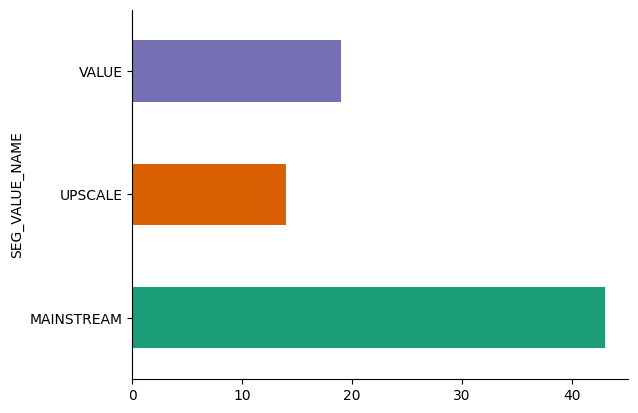

In [46]:
# @title SEG_VALUE_NAME

from matplotlib import pyplot as plt
import seaborn as sns
store_df.groupby('SEG_VALUE_NAME').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

`LABEL ENCODING SEG_VALUE_NAME`


In [47]:
store_df.replace({'SEG_VALUE_NAME':{'VALUE':1,'MAINSTREAM':2,'UPSCALE':3}})

,STORE_ID,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
0,367,KY,17140,1,196.0,24721,12707
1,389,KY,17140,2,408.0,46073,24767
2,613,TX,19100,2,464.0,64926,29386
3,623,TX,26420,2,NaN,46930,36741
4,2277,OH,17140,3,NaN,81958,54053
...,...,...,...,...,...,...,...
71,26981,OH,44220,2,NaN,42081,25122
72,26983,OH,19380,1,NaN,48782,31461
73,27175,TX,26420,3,NaN,50224,24902
74,28909,OH,17140,2,NaN,85876,28986


In [48]:
store_ohe = pd.get_dummies(store_df, columns=['ADDRESS_STATE_PROV_CODE', 'MSA_CODE'])

In [49]:
store_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   STORE_ID                    76 non-null     int32  
 1   SEG_VALUE_NAME              76 non-null     object 
 2   PARKING_SPACE_QTY           25 non-null     float64
 3   SALES_AREA_SIZE_NUM         76 non-null     int32  
 4   AVG_WEEKLY_BASKETS          76 non-null     int32  
 5   ADDRESS_STATE_PROV_CODE_IN  76 non-null     bool   
 6   ADDRESS_STATE_PROV_CODE_KY  76 non-null     bool   
 7   ADDRESS_STATE_PROV_CODE_OH  76 non-null     bool   
 8   ADDRESS_STATE_PROV_CODE_TX  76 non-null     bool   
 9   MSA_CODE_13140              76 non-null     bool   
 10  MSA_CODE_17140              76 non-null     bool   
 11  MSA_CODE_17780              76 non-null     bool   
 12  MSA_CODE_19100              76 non-null     bool   
 13  MSA_CODE_19380              76 non-nu

In [50]:
store_ohe.shape

(76, 18)

In [51]:
store_ohe.loc[0]

,0
STORE_ID,367
SEG_VALUE_NAME,VALUE
PARKING_SPACE_QTY,196.0
SALES_AREA_SIZE_NUM,24721
AVG_WEEKLY_BASKETS,12707
ADDRESS_STATE_PROV_CODE_IN,False
ADDRESS_STATE_PROV_CODE_KY,True
ADDRESS_STATE_PROV_CODE_OH,False
ADDRESS_STATE_PROV_CODE_TX,False
MSA_CODE_13140,False



## `PREPROCESSING: NUMERICAL FEATURES`

- Check and impute the missing values in the numerical features.
- Check for the outliers and treat them.


# `WEEKLY SALES DATA`

In [52]:
train.show(5)

+-------------+---------+----------+----------+-------+-------+-----+
|WEEK_END_DATE|STORE_NUM|       UPC|BASE_PRICE|FEATURE|DISPLAY|UNITS|
+-------------+---------+----------+----------+-------+-------+-----+
|    14-Jan-09|      367|1111009477|      1.57|      0|      0|   13|
|    14-Jan-09|      367|1111009497|      1.39|      0|      0|   20|
|    14-Jan-09|      367|1111085319|      1.88|      0|      0|   14|
|    14-Jan-09|      367|1111085345|      1.88|      0|      0|   29|
|    14-Jan-09|      367|1111085350|      1.98|      0|      0|   35|
+-------------+---------+----------+----------+-------+-------+-----+
only showing top 5 rows



---

### `WEEKLY SALES DATA`  has the following numerical features

    - BASE_PRICE
    - UNITS (Target)
    
---   

In [53]:
train.select([count(when(isnull(c),c)).alias(c) for c in train.columns]).show()

+-------------+---------+---+----------+-------+-------+-----+
|WEEK_END_DATE|STORE_NUM|UPC|BASE_PRICE|FEATURE|DISPLAY|UNITS|
+-------------+---------+---+----------+-------+-------+-----+
|            0|        0|  0|        12|      0|      0|    0|
+-------------+---------+---+----------+-------+-------+-----+



 Here we can see `BASE_PRICE` columns has `12` null values  

Imputing the missing values in the `BASE_PRICE`

In [55]:
# We'll fill the null values with the average values of Base_Price


In [56]:
train.select([count(when(isnull(c),c)).alias(c) for c in train.columns]).show()

+-------------+---------+---+----------+-------+-------+-----+
|WEEK_END_DATE|STORE_NUM|UPC|BASE_PRICE|FEATURE|DISPLAY|UNITS|
+-------------+---------+---+----------+-------+-------+-----+
|            0|        0|  0|         0|      0|      0|    0|
+-------------+---------+---+----------+-------+-------+-----+



# Task
Fill the missing values in the `BASE_PRICE` column of the `train` DataFrame with the mean `BASE_PRICE` for each corresponding `STORE_NUM`.

## Calculate mean base price per store

### Subtask:
Calculate the mean of `BASE_PRICE` for each `STORE_NUM` in the `train` DataFrame, considering only non-null `BASE_PRICE` values.


**Reasoning**:
Calculate the average base price for each store number to prepare for filling missing values.



In [57]:
from pyspark.sql.functions import avg

store_base_price_avg = train.groupBy("STORE_NUM").agg(avg("BASE_PRICE").alias("mean_base_price"))

In [58]:
train_joined = train.join(store_base_price_avg, on="STORE_NUM", how="left")
train_joined.show(5)

+---------+-------------+----------+----------+-------+-------+-----+------------------+
|STORE_NUM|WEEK_END_DATE|       UPC|BASE_PRICE|FEATURE|DISPLAY|UNITS|   mean_base_price|
+---------+-------------+----------+----------+-------+-------+-----+------------------+
|      367|    14-Jan-09|1111009477|      1.57|      0|      0|   13|3.4998979591836448|
|      367|    14-Jan-09|1111009497|      1.39|      0|      0|   20|3.4998979591836448|
|      367|    14-Jan-09|1111085319|      1.88|      0|      0|   14|3.4998979591836448|
|      367|    14-Jan-09|1111085345|      1.88|      0|      0|   29|3.4998979591836448|
|      367|    14-Jan-09|1111085350|      1.98|      0|      0|   35|3.4998979591836448|
+---------+-------------+----------+----------+-------+-------+-----+------------------+
only showing top 5 rows



In [62]:
train = train_joined.withColumn("BASE_PRICE", when(train_joined["BASE_PRICE"].isNull(), train_joined["mean_base_price"]).otherwise(train_joined["BASE_PRICE"]))

In [63]:
train.select([count(when(isnull(c),c)).alias(c) for c in train.columns]).show()

+---------+-------------+---+----------+-------+-------+-----+---------------+
|STORE_NUM|WEEK_END_DATE|UPC|BASE_PRICE|FEATURE|DISPLAY|UNITS|mean_base_price|
+---------+-------------+---+----------+-------+-------+-----+---------------+
|        0|            0|  0|         0|      0|      0|    0|              0|
+---------+-------------+---+----------+-------+-------+-----+---------------+



In [64]:

train.drop("mean_base_price").show(5)

+---------+-------------+----------+----------+-------+-------+-----+
|STORE_NUM|WEEK_END_DATE|       UPC|BASE_PRICE|FEATURE|DISPLAY|UNITS|
+---------+-------------+----------+----------+-------+-------+-----+
|      367|    14-Jan-09|1111009477|      1.57|      0|      0|   13|
|      367|    14-Jan-09|1111009497|      1.39|      0|      0|   20|
|      367|    14-Jan-09|1111085319|      1.88|      0|      0|   14|
|      367|    14-Jan-09|1111085345|      1.88|      0|      0|   29|
|      367|    14-Jan-09|1111085350|      1.98|      0|      0|   35|
+---------+-------------+----------+----------+-------+-------+-----+
only showing top 5 rows



In [93]:
# Converting Spark Dataframe into pandas
train_df = train.toPandas()

In [94]:
train_df.drop('mean_base_price',axis=1,inplace=True)

In [95]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232287 entries, 0 to 232286
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   STORE_NUM      232287 non-null  int32  
 1   WEEK_END_DATE  232287 non-null  object 
 2   UPC            232287 non-null  int64  
 3   BASE_PRICE     232287 non-null  float64
 4   FEATURE        232287 non-null  int32  
 5   DISPLAY        232287 non-null  int32  
 6   UNITS          232287 non-null  int32  
dtypes: float64(1), int32(4), int64(1), object(1)
memory usage: 8.9+ MB


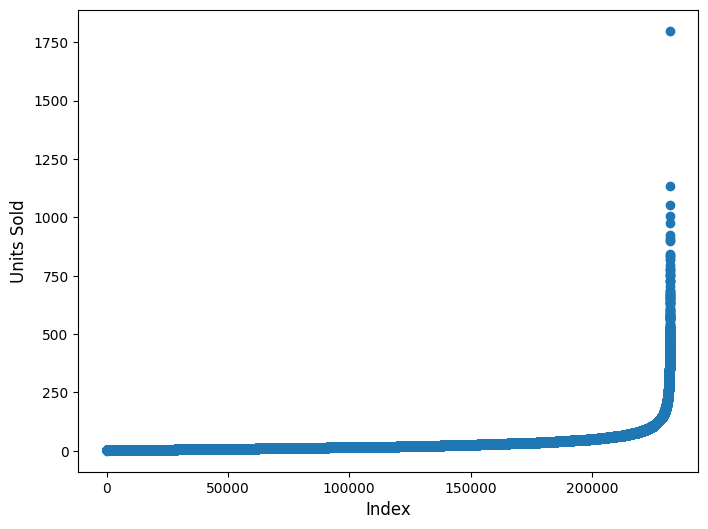

In [96]:
%matplotlib inline
plt.figure(figsize=(8,6))
plt.scatter(x = range(train_df.shape[0]), y = np.sort(train_df['UNITS'].values))
plt.xlabel('Index', fontsize=12)
plt.ylabel('Units Sold', fontsize=12)
plt.show()

In [97]:
# Identify potential outliers based on the scatter plot
# We can look at values that are significantly larger than the majority
outlier_threshold = train_df['UNITS'].quantile(0.99) # Using 99th percentile as a threshold
outliers = train_df[train_df['UNITS'] > outlier_threshold]['UNITS']

print("Potential outlier values in 'UNITS':")
print(outliers.sort_values(ascending=False))

Potential outlier values in 'UNITS':
7960      1800
11209     1136
9597      1054
7893      1006
215699     974
          ... 
27847      168
177712     168
180203     168
175137     168
111037     168
Name: UNITS, Length: 2316, dtype: int32


In [98]:
train_df.drop(train_df[train_df['UNITS'] > 750].index, axis = 0, inplace= True)

In [103]:
train_df[train_df['UNITS'] > 750].shape[0]

0

# `PRODUCT DATA` HAS NO NUMERICAL FEATURES

# `STORE DATA "store_ohe"` HAS FOLLOWING NUMERICAL FEATURES
- PARKING_SPACE_QTY
- SALES_AREA_SIZE_NUM
- AVG_WEEKLY_BASKETS

In [105]:
store_ohe.shape

(76, 18)

In [106]:
store_ohe[['PARKING_SPACE_QTY','AVG_WEEKLY_BASKETS','SALES_AREA_SIZE_NUM']].isna().sum()

,0
PARKING_SPACE_QTY,51
AVG_WEEKLY_BASKETS,0
SALES_AREA_SIZE_NUM,0


- `PARKING_SPACE_QTY` - Check its correlation with the `SALES_AREA_SIZE_NUM`

In [107]:
store_ohe[['PARKING_SPACE_QTY','SALES_AREA_SIZE_NUM']].corr()

,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM
PARKING_SPACE_QTY,1.000000,0.763274
SALES_AREA_SIZE_NUM,0.763274,1.000000


from matplotlib import pyplot as plt
_df_0['PARKING_SPACE_QTY'].plot(kind='hist', bins=20, title='PARKING_SPACE_QTY')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['SALES_AREA_SIZE_NUM'].plot(kind='hist', bins=20, title='SALES_AREA_SIZE_NUM')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='PARKING_SPACE_QTY', y='SALES_AREA_SIZE_NUM', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['SALES_AREA_SIZE_NUM']
  ys = series['PARKING_SPACE_QTY']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('SALES_AREA_SIZE_NUM', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('SALES_AREA_SIZE_NUM')
_ = plt.ylabel('PARKING_SPACE_QTY')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['SALES_AREA_SIZE_NUM']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'SALES_AREA_SIZE_NUM'}, axis=1)
              .sort_values('SALES_AREA_SIZE_NUM', ascending=True))
  xs = counted['SALES_AREA_SIZE_NUM']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('SALES_AREA_SIZE_NUM', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('SALES_AREA_SIZE_NUM')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['PARKING_SPACE_QTY'].plot(kind='line', figsize=(8, 4), title='PARKING_SPACE_QTY')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['SALES_AREA_SIZE_NUM'].plot(kind='line', figsize=(8, 4), title='SALES_AREA_SIZE_NUM')
plt.gca().spines[['top', 'right']].set_visible(False)

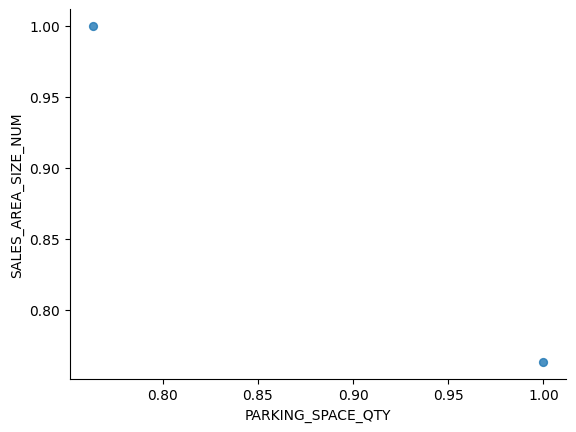

In [108]:
from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='PARKING_SPACE_QTY', y='SALES_AREA_SIZE_NUM', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Since the correlation of the **PARKING_SPACE_QTY** with **SALES_AREA_SIZE_NUM** is high so we can drop this column as it will not add much value to the model.

In [110]:
store_ohe = store_ohe.drop('PARKING_SPACE_QTY',axis=1,inplace=True)

KeyError: "['PARKING_SPACE_QTY'] not found in axis"

In [111]:
store_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   STORE_ID                    76 non-null     int32 
 1   SEG_VALUE_NAME              76 non-null     object
 2   SALES_AREA_SIZE_NUM         76 non-null     int32 
 3   AVG_WEEKLY_BASKETS          76 non-null     int32 
 4   ADDRESS_STATE_PROV_CODE_IN  76 non-null     bool  
 5   ADDRESS_STATE_PROV_CODE_KY  76 non-null     bool  
 6   ADDRESS_STATE_PROV_CODE_OH  76 non-null     bool  
 7   ADDRESS_STATE_PROV_CODE_TX  76 non-null     bool  
 8   MSA_CODE_13140              76 non-null     bool  
 9   MSA_CODE_17140              76 non-null     bool  
 10  MSA_CODE_17780              76 non-null     bool  
 11  MSA_CODE_19100              76 non-null     bool  
 12  MSA_CODE_19380              76 non-null     bool  
 13  MSA_CODE_26420              76 non-null     bool  
 


### `SAVE THE UPDATED FILES`

In [112]:
train_df.to_csv('/content/drive/MyDrive/Colab Notebooks/DataSet/processed_train.csv',index=False)
store_ohe.to_csv('/content/drive/MyDrive/Colab Notebooks/DataSet/processed_store.csv',index=False)
product_df.to_csv('/content/drive/MyDrive/Colab Notebooks/DataSet/processed_product.csv',index=False)